In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime as dt

In [2]:
df = pd.read_excel('online_retail_wrangled.xlsx')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [13]:
df['InvoiceDate'].dt.strftime('%y-%d-%m %h:%m:%s').sort_values()

0         2009-12-01 07:45:00
1         2009-12-01 07:45:00
2         2009-12-01 07:45:00
3         2009-12-01 07:45:00
4         2009-12-01 07:45:00
                 ...         
417074    2010-12-09 20:01:00
417075    2010-12-09 20:01:00
417076    2010-12-09 20:01:00
417062    2010-12-09 20:01:00
417110    2010-12-09 20:01:00
Name: InvoiceDate, Length: 520627, dtype: object

#### Customer Feature Engineering

At this point in our EDA, we want to engineer features related to our RFM analysis and otherwise helpful to our analysis. These include: total spending by customer, number of purchases, time since last purchase, etc. We'll use a pivot table to calculate this information all at once.

In [5]:
cust_purchases = pd.pivot_table(df,index=['Customer ID'],values=['Invoice','InvoiceDate','Item Total'],aggfunc={'Invoice':pd.Series.nunique,'InvoiceDate':np.max,'Item Total':np.sum})

In [6]:
cust_purchases

,Invoice,InvoiceDate,Item Total
Customer ID,,,
1,1,2010-12-06 16:57:00,7272.41
2,1,2010-12-09 14:09:00,6382.71
3,1,2010-12-07 15:28:00,5457.72
4,1,2010-12-06 09:58:00,6471.71
5,1,2010-12-03 11:36:00,6369.56
...,...,...,...
18283,6,2010-11-22 15:30:00,641.77
18284,2,2010-10-06 12:31:00,436.68
18285,1,2010-02-17 10:24:00,427.00


Now we have columns for each customer's frequency and monetary value. To generate a "recency" score, we'll generate a column that is the number of days since the customer's most recent purchase.

In [14]:
cust_purchases['lastday'] = dt.datetime(2010,12,9)

In [15]:
cust_purchases['last_transact'] = cust_purchases['lastday'] - cust_purchases['InvoiceDate']

In [17]:
cust_purchases['last_transact'] = cust_purchases['last_transact'].dt.days

In [20]:
cust_purchases.loc[cust_purchases['last_transact'] <= 0, 'last_transact'] = 0

In [27]:
cust_purchases.rename(columns={'Invoice':'freq','Item Total':'mv','last_transact':'rec'},inplace=True)
cust_purchases.drop(['InvoiceDate','lastday'],axis=1,inplace=True)

In [28]:
cust_purchases

,freq,mv,rec
Customer ID,,,
1,1,7272.41,2
2,1,6382.71,0
3,1,5457.72,1
4,1,6471.71,2
5,1,6369.56,5
...,...,...,...
18283,6,641.77,16
18284,2,436.68,63
18285,1,427.00,294


In [29]:
cust_purchases.describe()

,freq,mv,rec
count,6327.000000,6327.000000,6327.000000
mean,4.030978,1494.712126,116.099257
std,8.602067,7289.995315,109.444873
min,1.000000,-53594.360000,0.000000
25%,1.000000,138.665000,23.000000
50%,1.000000,467.500000,71.000000
75%,4.000000,1379.125000,196.000000
max,270.000000,341776.730000,372.000000


Now, with the describe method, we can pull out some interesting information. 
* At least half of the customers have only made one purchase during the 18 months covered by this dataset.
* Our mean monetary value per customer is greater than the 75th percentile, indicating that there are some customers with such a large monetary value that they are skewing our mean. Our median mv is roughly 1/3 of our mean mv, which means we should be cautious using that as a meaningful metric.
* We see a similar skew in the recency of purchases - the average time elapsed since last purchase (i.e., the delta between the end of the dataset 9-12-2010 and the most recent transaction) is 116 days, but the 50th percentile is 71 days. 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7E3D31288>,
      dtype=object)

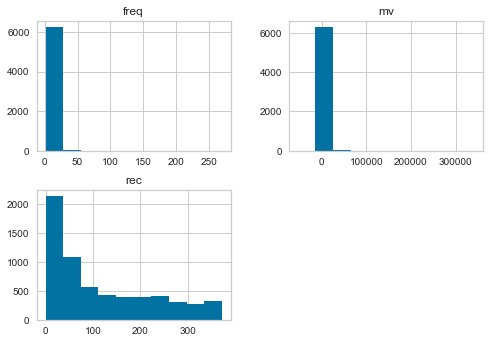

In [30]:
cust_purchases.hist()

Upon looking at these graphs, it feels like there are some quick intuitions we can pull out. 
* The recency graph shows that a number of customers have a most recent purchase in the last 90 days. That, in combination with the relatively low frequency overall (i.e., the mean number of purchases per customer is 4) could indicate a recent uptick in customer acquisition. The end of the dataset is in September, which could indicate the beginning of a holiday season.
* There are some customers with negative total values. Based on earlier analysis, these customers engagements span the length of the time period covered by the dataset (so they aren't for example caused by a number of returns at the beginning of the dataset time period).
* The vast majority of users are low-frequency purchasers. This could indicate a potential area for investment in customer retention.

#### Checking for outliers

We see that some outliers are exerting pressure on the skew of our data. Let's see how those shake out in practice.

In [60]:
mv = cust_purchases['mv']
freq = cust_purchases['freq']
rec = cust_purchases['rec']

In [67]:
mv_idxr = mv.between(mv.quantile(.025),mv.quantile(.975))


In [ ]:
cust = cust_purchases.loc[mv_idxr]

{'whiskers': [<matplotlib.lines.Line2D at 0x1f82a195688>,
 'caps': [<matplotlib.lines.Line2D at 0x1f82a1a5e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f82a1a52c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f82a197cc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f82a197e08>],
 'means': []}

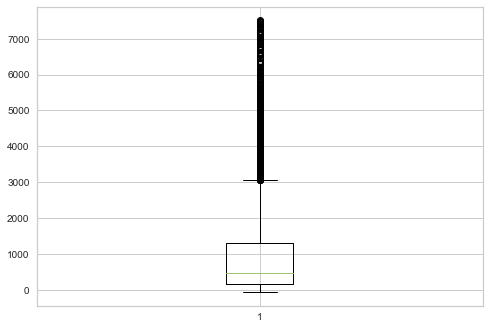

In [94]:
plt.boxplot(cust['mv'])

Based on the above, we can see that 95% of customers fall between close to 0 and nearly 8000 dollars. For the purposes of revenue generation through customer segmentation, it thus makes sense to remove "negative value" customers and those representing a significant portion of transactions. 

{'whiskers': [<matplotlib.lines.Line2D at 0x1f829fc9388>,
 'caps': [<matplotlib.lines.Line2D at 0x1f829fdaf08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f829fd0f48>],
 'medians': [<matplotlib.lines.Line2D at 0x1f829fcb908>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f829fcbdc8>],
 'means': []}

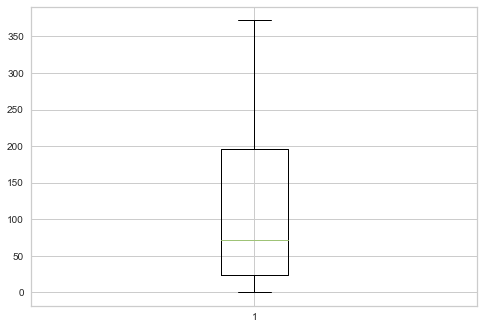

In [92]:
plt.boxplot(cust['rec'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f82a0edb48>,
 'caps': [<matplotlib.lines.Line2D at 0x1f82a13ef48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f82a13e808>],
 'medians': [<matplotlib.lines.Line2D at 0x1f82a141d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f82a141d88>],
 'means': []}

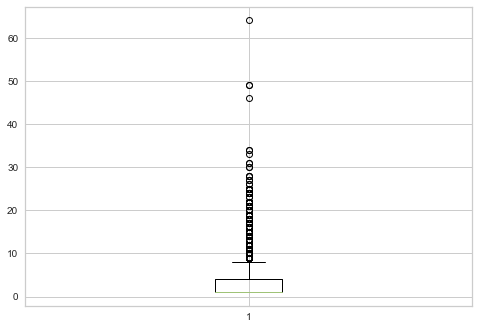

In [93]:
plt.boxplot(cust['freq'])

Simply indexing to the middle 95% of customers in terms of monetary value has removed a lot of outliers in all dimensions. We can handle those extreme outliers in a separate, narrative analysis.

At this time we'll scale our data such that we can start to use unsupervised learning methods to segment our customer base.

In [102]:
scaler = StandardScaler()

In [104]:
cust_scaled = scaler.fit_transform(cust)

In [113]:
cust

,freq,mv,rec
Customer ID,,,
1,1,7272.41,2
2,1,6382.71,0
3,1,5457.72,1
4,1,6471.71,2
5,1,6369.56,5
...,...,...,...
18283,6,641.77,16
18284,2,436.68,63
18285,1,427.00,294


In [110]:
new_df = pd.DataFrame(cust_scaled,columns=['freq','mv','rec'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f82a3468c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1f82a35ad08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f82a35a588>],
 'medians': [<matplotlib.lines.Line2D at 0x1f82a35fe88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f82a35ffc8>],
 'means': []}

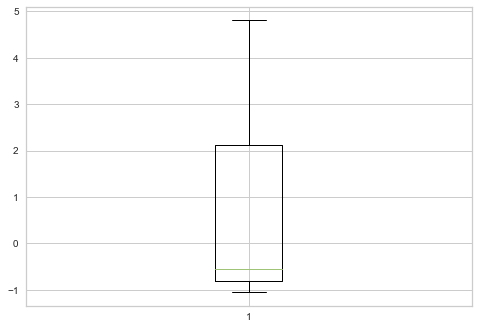

In [108]:
plt.boxplot(cust_scaled[0])

In [112]:
new_df.to_csv('online_retail_scaled.csv')

In [114]:
cust.to_excel('online_retail_cust_ids.xlsx')